Versions:
* v1: Nepal Data, EMA implementation start. First working test with EMA
* v2: Finish of first iteration of Optimisation and Uncertainty analysis
* v3: Finish first version of Robustness analysis & MORDM
* v4: Clean up MORDM - very minor
* v5: Change model v1 to v2 + clean up
* v6: Change model to v5 + clean up
* v7: Change model to v6: include real distance matrix + constraint for all_fls_in_use
    * with model v6: not MORDM tested
* v8: Add plotting folium
* v9: Update model with good data and units - MORDM tested
    * With model v8: Verified to produce same results as mordm method in MPMORDM v7 
* v10: New model (v9), changed equity objective
    * Verified new equity function
    * Validaded travel times with OSM

        

TODO inputdata: 
* FL not random generation
* distances based on OSRM route matrix

<b> OSRM </b><br>
for installation:

pip install git+https://github.com/ustroetz/python-osrm

In [101]:
# Standard imports
import random
import pandas as pd
import numpy as np

# Own Model import
from lib.fl_model_v9 import *
import lib
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
# from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

import importlib


In [102]:
import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [103]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [104]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
pandas,0.23.0,,
re,2.2.1,,


# FL Model test

Moved to different Notebook

# FL Model Nepal

## Nepal Data Load


In [105]:
DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
DPs.columns

Index(['name', 'population', 'latitude', 'longitude'], dtype='object')

In [106]:
FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
FLs.columns

Index(['Name', 'Lat', 'Lon'], dtype='object')

In [107]:
SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
SPs.columns

Index(['name', 'latitude_deg', 'longitude_deg'], dtype='object')

## Nepal Instantiation 

In [108]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}


# For checking without randomness
DSRDP = {"DSRDP{}".format(i): random.uniform (1.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (1.5, 1.5) for i in range(len(FLX))}

# Decision Variables
start_situation = {key:0 for key in FLs.Name}

## Create distance matrix

In [109]:
node_names = ["SP{}".format(i) for i, ind in enumerate(SPs.index)] + [
    "FL{}".format(i) for i, ind in enumerate(FLs.index)
] + ["DP{}".format(i) for i, ind in enumerate(DPs.index)]

### OSRM routing table

In [110]:
#node_lats = SPs['Latitude (DD)'].append(FLs['Lat']).append(DPs['Latitude (DD)']).reset_index(drop=True)

In [111]:
# node_lons = SPs['Longitude (DD)'].append(FLs['Lon']).append(DPs['Longitude (DD)']).reset_index(drop=True)

In [112]:
# import osrm

In [113]:
# osrm.RequestConfig.host = osrm.RequestConfig.host = "router.project-osrm.org"

In [114]:
# # for some reason the coordinates are incorrectly passed by this OSRM package
# list_coords = [osrm.Point(longitude=lat, latitude=lon) for lat, lon in zip (node_lats, node_lons)]

In [115]:
# time_matrix, snapped_coords, a = osrm.table(
#     list_coords, ids_origin=node_names, output='dataframe')

time_matrix.to_csv("Data/routes_play_data.csv")

In [116]:
# time_matrix.head()

In [117]:
# time_matrix.to_csv("Data/routes_play_data_numpy.csv",index=False)

In [118]:
# time_matrix = pd.read_csv("Data/routes_play_data_numpy.csv")
# time_matrix = pd.read_csv("prepared_data/Nepal/routing_table.csv")

# time_matrix.index = node_names

In [119]:
# test2 = pd.read_csv('Data/routes_play_data_numpy.csv')
# test2 = test2.values

In [120]:
# time_matrix.head(2)

## Nepal Model Evaluator

Testing

In [121]:
FL_model = importlib.reload(lib.fl_model_v9).FL_model

In [125]:
start_situation = {key:0 for key in FLs.Name}
# start_situation['FLO1'] = 1
# start_situation['FLO4'] = 1
start_situation['FLO5'] = 1
# a = []
# a.append(
a = FL_model(
    unit_opening_costs = 1,
    unit_transport_cost= 1, #cost per hour/ dollar or euroXX
    FL_operations_cost = 10,
    demand_per_affected = 1, # units per 1000 affected people
    graphical_representation = True,
    FL_range=4, # in hours. km? --> meters
    dist_method="from_table", #"great_circle",
    table_dir = "Nepal/Prepared Input Data/routing_table.csv",
    lorry_speed="nope", #km/h? -->m/s
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **start_situation,
    **DSRDP,
    **DSRFL,
    **DPpop)


In [126]:
a

(11.0,
 35,
 1820.2495,
 129939.15000000001,
 False,
 <folium.folium.Map at 0x1f5ae8ac6a0>)

In [127]:
a[5]

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

In [128]:
start_situation = {key:0 for key in FLs.Name}
current_situation = start_situation

In [129]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """
    def natural_key(string_):
        return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
    
    # All FL names
    FL_keys = sorted(FL_dict.keys(),key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    if print_pols == True:
        print("total policies:",len(policy_list))
        for n,i in enumerate(policy_list):
            for v in i.values():
                print (int(v), end='')
            print(" <- policy {}".format(n))
                
    return policy_list

In [130]:
optional_policies = create_policies(current_situation, print_pols=False)

In [131]:
# %%timeit
# Evaluate all optional policies with best estimate values
best_est_results_opt_pols = []
for policy in optional_policies:
    best_est_results_opt_pols.append(
        FL_model(
            unit_opening_costs=100,
            unit_transport_cost=1,  #cost per hour/ dollar or euroXX
            FL_operations_cost=30,
            demand_per_affected=20,  # units per 1000 affected people
            graphical_representation=False,
            FL_range=4,  # in hours. km? --> meters
            dist_method="from_table",  #"great_circle",
            table_dir="Nepal/Prepared Input Data/routing_table.csv",
            #     unit_opening_costs = 1,
            #     unit_transport_cost= 1,
            #     FL_operations_cost = 10,
            #     graphical_representation = False,
            #     FL_range=22400, # in seconds. km? --> meters
            #     dist_method="from_table", #"great_circle",
            #     table_dir = "Data/routes_play_data_numpy.csv",
            #     lorry_speed=40, #km/h? -->m/s
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [133]:
len(optional_policies)

20

## Original from here

In [134]:
# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_distr_time'
]
# Put outcomes in DF

df_best_est_results_opt_pols = pd.DataFrame(
    np.asarray(best_est_results_opt_pols)[:, :5],
    columns=oois + ["constraint"])
df_best_est_results_opt_pols.head()

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time,constraint
0,86309.8,29,31669.4,125448,True
1,47957.9,24,14858.8,97976.4,True
2,8788.42,34,36091.2,108008,True
3,30169.2,25,14868.8,96194.2,True
4,11683.9,34,35925.1,138030,True


In [135]:
# constraint
df_best_est_results_opt_pols = df_best_est_results_opt_pols[df_best_est_results_opt_pols.constraint == 1]

df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

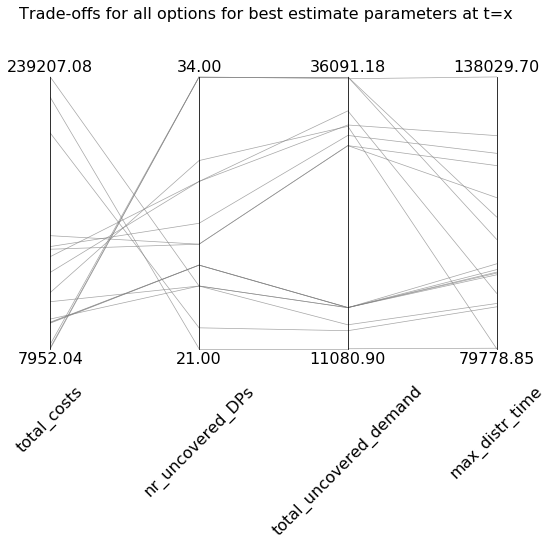

In [136]:
title = "Trade-offs for all options for best estimate parameters at t=x"
plot_optimal(df_best_est_results_opt_pols, oois, title)

In [137]:
# options for pareto sorting# minimising is default
kwargs = {"maximize_all": True}
kwargs2 = {"maximize": [0, 1]}

nondominated_BE_policy_results = np.array(pareto.eps_sort(
    [list(df_best_est_results_opt_pols.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

#Filter out those where new demand is covered
# nondominated_BE_policy_results = nondominated_BE_policy_results[nondominated_BE_policy_results[:,4] != 0]

# Put outcomes in DF
df_nondominated_BE_policy_results = pd.DataFrame(
    np.asarray(nondominated_BE_policy_results),
    columns=["pol_i"] + oois).set_index("pol_i")
df_nondominated_BE_policy_results

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
pol_i,,,,
4.0,11683.907413,34.0,35925.15,138029.70
7.0,72927.061470,29.0,32965.59,91651.95
8.0,55769.388998,30.0,31545.49,79778.85
11.0,221874.205841,21.0,11080.90,79886.70
13.0,191454.849195,22.0,12740.58,88762.05
14.0,29714.298035,25.0,14868.83,95623.80
16.0,33213.748867,24.0,14858.83,96730.05
19.0,7952.041135,34.0,36091.18,103207.05


In [138]:
df_nondominated_BE_policy_results

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
pol_i,,,,
4.0,11683.907413,34.0,35925.15,138029.70
7.0,72927.061470,29.0,32965.59,91651.95
8.0,55769.388998,30.0,31545.49,79778.85
11.0,221874.205841,21.0,11080.90,79886.70
13.0,191454.849195,22.0,12740.58,88762.05
14.0,29714.298035,25.0,14868.83,95623.80
16.0,33213.748867,24.0,14858.83,96730.05
19.0,7952.041135,34.0,36091.18,103207.05


In [139]:
nondominated_BE_policy_results

array([[4.00000000e+00, 1.16839074e+04, 3.40000000e+01, 3.59251500e+04,
        1.38029700e+05],
       [7.00000000e+00, 7.29270615e+04, 2.90000000e+01, 3.29655900e+04,
        9.16519500e+04],
       [8.00000000e+00, 5.57693890e+04, 3.00000000e+01, 3.15454900e+04,
        7.97788500e+04],
       [1.10000000e+01, 2.21874206e+05, 2.10000000e+01, 1.10809000e+04,
        7.98867000e+04],
       [1.30000000e+01, 1.91454849e+05, 2.20000000e+01, 1.27405800e+04,
        8.87620500e+04],
       [1.40000000e+01, 2.97142980e+04, 2.50000000e+01, 1.48688300e+04,
        9.56238000e+04],
       [1.60000000e+01, 3.32137489e+04, 2.40000000e+01, 1.48588300e+04,
        9.67300500e+04],
       [1.90000000e+01, 7.95204114e+03, 3.40000000e+01, 3.60911800e+04,
        1.03207050e+05]])

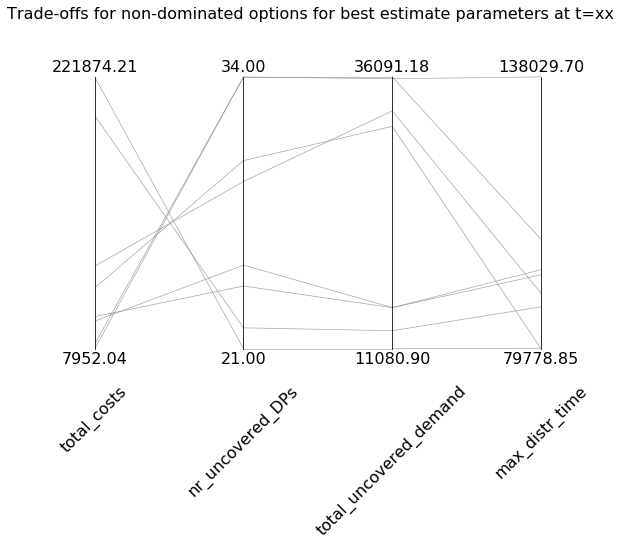

In [140]:
title = "Trade-offs for non-dominated options for best estimate parameters at t=xx"
plot_optimal(df_nondominated_BE_policy_results, oois, title)

In [142]:
# policies for all nondominated policies
nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]

nondominated_BE_policies = np.array(optional_policies)[nondom_i]
print(nondom_i)
nondominated_BE_policies

[4, 7, 8, 11, 13, 14, 16, 19]


array([{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.

#### visualise all nondom pols

In [23]:
# inspect nondominated results

all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}

a = FL_model(
    unit_opening_costs = 1,
    unit_transport_cost= 1, #cost per hour/ dollar or euroXX
    FL_operations_cost = 10,
    demand_per_affected = 1, # units per 1000 affected people
    graphical_representation = True,
    FL_range=4, # in hours. km? --> meters
    dist_method="from_table", #"great_circle",
    table_dir = "prepared_data/Nepal/routing_table.csv",
    lorry_speed="nope", #km/h? -->m/s
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **all_nondom_BE_pols,
    **DSRDP,
    **DSRFL,
    **DPpop)
print("These are all the FLs that are in the set of non-dominated policies")
a[5]

These are all the FLs that are in the set of non-dominated policies


# EMA Framework

## EMA instantiations

In [24]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)

model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['longitude'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['latitude'])
] + [
    Constant("SPX{}".format(i), x)
    for i, x in zip(SPs.index, SPs['longitude_deg'])
] + [
    Constant("SPY{}".format(i), y)
    for i, y in zip(SPs.index, SPs['latitude_deg'])
] + [Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])] + [
    Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
]

# model.locations_uncertain =   [
#     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
# ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

model.constants = [
    Constant('graphical_representation', False),
    Constant('dist_method', 'from_table'),
    Constant('table_dir', 'prepared_data/Nepal/routing_table.csv')
    #list of other constants
] + model.locations + [  # population DPs
    Constant("DPpop{}".format(i), pop)
    for i, pop in zip(DPs.index, DPs['population'])
]

# Reachability of Demand Points and Facility Locations can be disrupted
# Disruption also determines demand (disr-1)*pop
model.disruptions = [
    #For Validation
    RealParameter("DSRFL{}".format(i), 1.49, 1.51) for i in range(FLs.shape[0])
] + [RealParameter("DSRDP{}".format(i), 1.49, 1.51) for i in range(DPs.shape[0])]


model.uncertainties = [
    RealParameter('unit_opening_costs', 50, 200),
    RealParameter('unit_transport_cost', 0.5,2),  # #cost per hour/ dollar or euroXX
    RealParameter('FL_operations_cost', 20, 50),
    RealParameter('FL_range', 2, 6),  # km TODO: great circle distance
    RealParameter(
        'demand_per_affected', 10, 50),  #units per 1000 affected people
    #list of other uncertainties
] + model.disruptions  #+ model.locations_uncertain

model.outcomes = [
    ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome(
        "max_distr_time",
        kind=ScalarOutcome.MINIMIZE,
    )
]

models.append(model)

In [25]:
if [o.name for o in models[0].outcomes] != oois:
    print("Watch out! Oois and model outcome names are not similar!")

In [26]:
for model in models:
    print(model.name)

flmodelt0


In [27]:
nondominated_BE_policies_EMA = []
for name, pol in zip(nondom_i,nondominated_BE_policies):
    nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

In [28]:
time1 = time.time()
all_scen_results_nondom_pols = perform_experiments(model,1000,nondominated_BE_policies_EMA)
time2 = time.time()
print("Total time:{}".format(time2-time1),"\n","time per run = {}".format((time2-time1)/1000))

[MainProcess/INFO] performing 1000 scenarios * 5 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished


Total time:56.76556921005249 
 time per run = 0.05676556921005249


timelog: (3000 experiments)
1. possibly with cpu problems due to failed multiprocessing <br>
Total time:186.64591431617737 <br>
time per run = 0.18664591431617736
2. model v2 <br>
Total time:156.22968077659607  <br>
 time per run = 0.15622968077659607
3. model v2 4 policies <br>
Total time:200.71212720870972 
 time per run = 0.2007121272087097
4. 
Total time:144.36057209968567 <br>
 time per run = 0.14436057209968567
 
5. 
Total time:69.68182039260864 <br>
 time per run = 0.06968182039260865
 
6. 5000 experiments <br>
time per run = 0.03758887338638306

In [29]:
# Add parameter in filename for period t=1,2...x
ema.save_results(all_scen_results_nondom_pols, "results/candidate_policy_robustness_v4.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\candidate_policy_robustness_v4.tar.gz


# Robustness Framework

In [30]:
all_scen_results_nondom_pols = ema.load_results("results/candidate_policy_robustness_v4.tar.gz")
experiments, outcomes = all_scen_results_nondom_pols

[MainProcess/INFO] results loaded succesfully from C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\candidate_policy_robustness_v4.tar.gz


In [31]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    return score

sigN_results = []

for policy in nondominated_BE_policies_EMA:
    #filter the outcome values corresponding to each policy using a logical index
    logical_index = experiments['policy']==int(policy.name)
    pol_outcomes = {key:outcomes[key][logical_index] for key in outcomes.keys()}
    temp_result = {}
    for ooi in models[0].outcomes:
        temp_result[ooi.name] = calculate_signalNoise(pol_outcomes[ooi.name], ooi.kind)
    sigN_results.append(temp_result)    


In [32]:
df_sigN = pd.DataFrame(sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])
df_sigN

,max_distr_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
4,2.188801e+09,89.520932,8.901580e+09,1.046682e+09
11,2.309070e+08,105.745610,9.225858e+10,3.592906e+08
13,2.404435e+08,127.358008,8.223831e+10,3.448485e+08
14,1.598746e+08,74.092762,3.465630e+09,1.949568e+08
19,1.344998e+09,42.066891,3.978416e+08,1.117502e+09


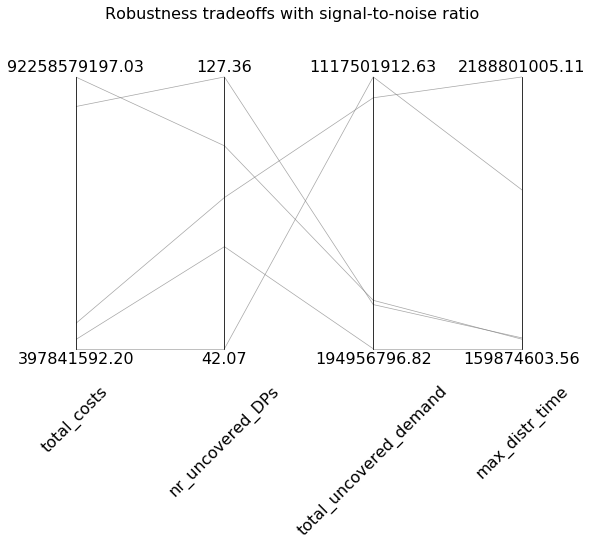

In [38]:

title = "Robustness tradeoffs with signal-to-noise ratio"
plot_optimal(df_sigN, oois, title)

In [39]:
def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    
    #determine the regret values for eaxh policy in each scenario
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])]
    
    max_regrets = np.max(regrets, axis=1)
    
    return max_regrets

In [40]:
reg_results = {}
# we need to iterate over the outcomes differently now, 
#because the maximum egret calculation requires the outcome values for all policies
for ooi in models[0].outcomes:
    data = []
    for policy in nondominated_BE_policies_EMA:
        logical_index = experiments['policy'] == int(policy.name) 
        data.append(outcomes[ooi.name][logical_index])
    reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    


In [41]:
reg_results

{'total_costs': array([ 445221.79164689, 1063529.76740491, 1086154.35213231,
         204589.67755035,   38086.02462304]),
 'nr_uncovered_DPs': array([15.,  4.,  4.,  8., 19.]),
 'total_uncovered_demand': array([62835.74187743, 40991.44617968, 38141.20878505, 13626.75117388,
        70454.81464107]),
 'max_distr_time': array([67532.77398095, 35934.52650808, 36124.86052518, 20203.5023789 ,
        90327.98322047])}

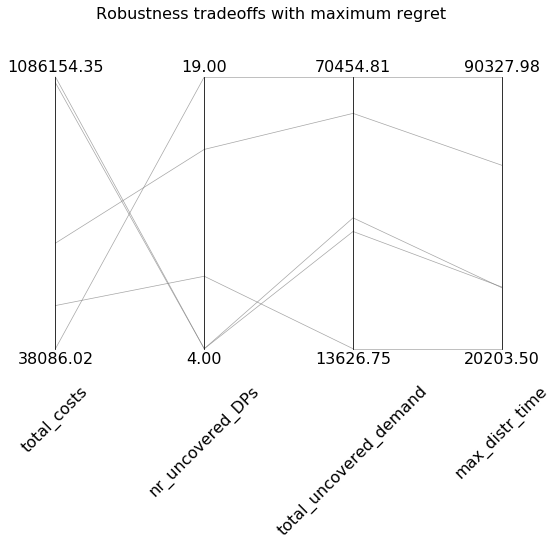

In [42]:
# we can again convert the robustness values into a dataframe. 
#However, since the results are in a dictionary, we need to do it differently.
df_regret = pd.DataFrame.from_dict(reg_results, orient='columns',)
df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]
title = "Robustness tradeoffs with maximum regret"
plot_optimal(df_regret, oois, title)

## Choose nondominated robust policies

In [43]:
df_regret

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
4,4.452218e+05,15.0,62835.741877,67532.773981
11,1.063530e+06,4.0,40991.446180,35934.526508
13,1.086154e+06,4.0,38141.208785,36124.860525
14,2.045897e+05,8.0,13626.751174,20203.502379
19,3.808602e+04,19.0,70454.814641,90327.983220


In [44]:
df_sigN

,max_distr_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
4,2.188801e+09,89.520932,8.901580e+09,1.046682e+09
11,2.309070e+08,105.745610,9.225858e+10,3.592906e+08
13,2.404435e+08,127.358008,8.223831e+10,3.448485e+08
14,1.598746e+08,74.092762,3.465630e+09,1.949568e+08
19,1.344998e+09,42.066891,3.978416e+08,1.117502e+09


In [45]:
all_robustness_scores = pd.merge(df_regret,df_sigN, left_index=True, right_index=True, suffixes=('_regret', '_sigN'))

In [46]:
all_robustness_scores

,total_costs_regret,nr_uncovered_DPs_regret,total_uncovered_demand_regret,max_distr_time_regret,max_distr_time_sigN,nr_uncovered_DPs_sigN,total_costs_sigN,total_uncovered_demand_sigN
4,4.452218e+05,15.0,62835.741877,67532.773981,2.188801e+09,89.520932,8.901580e+09,1.046682e+09
11,1.063530e+06,4.0,40991.446180,35934.526508,2.309070e+08,105.745610,9.225858e+10,3.592906e+08
13,1.086154e+06,4.0,38141.208785,36124.860525,2.404435e+08,127.358008,8.223831e+10,3.448485e+08
14,2.045897e+05,8.0,13626.751174,20203.502379,1.598746e+08,74.092762,3.465630e+09,1.949568e+08
19,3.808602e+04,19.0,70454.814641,90327.983220,1.344998e+09,42.066891,3.978416e+08,1.117502e+09


Use small epsilon value, because efficiency is not relevant (because of low numbers of alternatives, smaller epsilon is possible. larger epsilon leads to faster processing time)

In [47]:
# Non-dominated sorting for outcomes


# options for pareto sorting# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

robust_nondominated_policies = pareto.eps_sort([list(all_robustness_scores.itertuples(index=True))],[i+1 for i in range(all_robustness_scores.shape[1])], [1e-9] * all_robustness_scores.shape[1])
robust_nondominated_policies

[['11',
  1063529.7674049072,
  4.0,
  40991.44617968174,
  35934.52650807577,
  230907024.09667355,
  105.74561002133026,
  92258579197.03168,
  359290550.0262003],
 ['13',
  1086154.3521323144,
  4.0,
  38141.20878505437,
  36124.86052517665,
  240443452.05690387,
  127.35800794098219,
  82238310059.471,
  344848465.6432811],
 ['14',
  204589.67755034723,
  8.0,
  13626.751173881385,
  20203.502378897338,
  159874603.55850637,
  74.09276236534191,
  3465630352.3507886,
  194956796.81908458],
 ['19',
  38086.02462303968,
  19.0,
  70454.8146410652,
  90327.98322046627,
  1344997670.4664805,
  42.066890802365926,
  397841592.20144236,
  1117501912.6325066]]

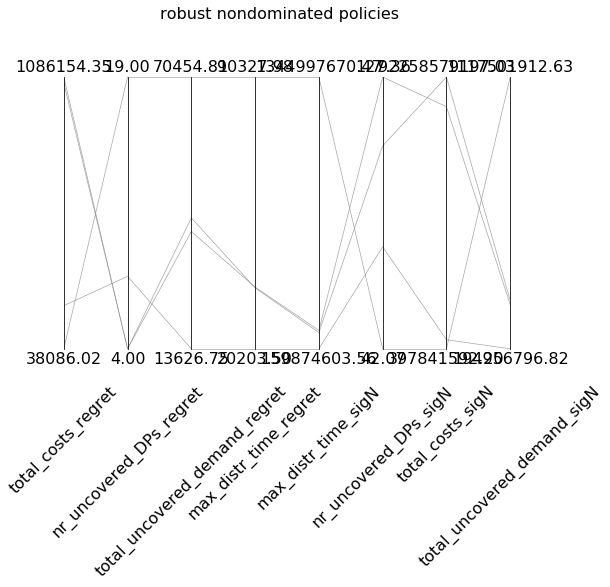

In [48]:
if len(robust_nondominated_policies) ==0:
    print("something went wrong")
elif len(robust_nondominated_policies) == 1:
    print(robust_nondominated_policies)
else:
    temp_cols = ["pol_i"]+list(all_robustness_scores.columns)

    df_temp = pd.DataFrame(robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    plot_optimal(df_temp, all_robustness_scores.columns, "robust nondominated policies")

In [45]:
np.asarray(robust_nondominated_policies)[:,0]

array(['11', '13', '14', '19'], dtype='<U18')

In [49]:
np.asarray(robust_nondominated_policies)[:,0]

array(['11', '13', '14', '19'], dtype='<U18')

# Next iteration Framework